In [6]:
import tensorflow as tf
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt

#### Creo un dataset sintetico al quale le mia y corrisponde sempre a 1.3 * x1 * x1 + 3.3 * x2 + 2.5

In [7]:
def my_function(x1, x2):
    return 1.3 * x1 * x1 + 3.3 * x2 + 2.5

examples_number = 20000
train_test_split = 18000

x = np.zeros((examples_number, 2), dtype='float32')
y = np.zeros((examples_number, 1), dtype='float32')

for i in range(examples_number):
    x1 = np.random.random(1) * 0.1 + 0.0001
    x2 = np.random.random(1) * 0.1 + 0.0001

    f = my_function(x1, x2)

    x[i][0] = x1
    x[i][1] = x2
    y[i][0] = f

x_train = x[:train_test_split]
y_train = y[:train_test_split]

x_val = x[train_test_split:]
y_val = y[train_test_split:]

#### Creo un dataset di test nel quale la funzione della y é la stessa ma i dati sono differenti dai dati di addestramento 

In [8]:
x_test = np.zeros((2000, 2), dtype='float32')
y_test = np.zeros((2000, 1), dtype='float32')

for i in range(2000):
    x1 = np.random.random(1) * 0.42 + 0.0001
    x2 = np.random.random(1) - 0.5 + 0.0001

    f = my_function(x1, x2)

    x_test[i][0] = x1
    x_test[i][1] = x2
    y_test[i][0] = f

In [9]:
print(np.min(x_train), np.max(x_train), np.min(y_train), np.max(y_train))
print(np.min(x_val), np.max(x_val), np.min(y_val), np.max(y_val))
print(np.min(x_test), np.max(x_test), np.min(y_test), np.max(y_test))

0.000100166806 0.10009845 2.5003803 2.8425431
0.00010256296 0.10009802 2.5014393 2.8426564
-0.49966294 0.49836445 0.8523469 4.3490763


In [10]:
trainings_log = {}

def train_and_test(name=None):
    start_time = datetime.now()
    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        batch_size=500,
        verbose=0,
        epochs=70
    )

    test_results = model.evaluate(x_test, y_test, verbose=0, batch_size=128)

    end_time = datetime.now()
    time_elapsed = end_time - start_time

    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val.Loss')
    plt.legend()
    plt.show()

    print('---------------------------------')
    print('LOSSES')
    print('train     ', history.history['loss'][-1])
    print('validation', history.history['val_loss'][-1])
    print('test      ', test_results)
    print('time elaps', time_elapsed)
    trainings_log[name] = {
        'train_loss': history.history['loss'][-1],
        'val_loss': history.history['val_loss'][-1],
        'test_loss': test_results,
        'time_elaps': time_elapsed
    }

#### Creo un'Architettura NALU 
L'Architettura di una cella NALU contiene al suo interno un una cella NAC semplice e una cella NAC complessa alle quali viene aggiunto un gate che definisci quali e quanti pesi di uscita delle due NAC devono essere sommati 

#### Definizione della classe 
* Vengono definiti i pesi come devono essere inizializzati dove M e W sono per la sigmoide e la tanh e G per il gate

* NAC Complessa = exp(log(∣x∣+ε)⋅W)

* NAC Semplice = (Wsigmoide * W tanh) * x

* (g * a) + ((1 - g) * m) é formula per determinare i pesi di output  

In [12]:
class NALU(tf.keras.layers.Layer):
    def __init__(
            self, units,
            G_constraint=None,
            G_initializer='glorot_uniform',
            G_regularizer=None,
            M_hat_constraint=None,
            M_hat_initializer='glorot_uniform',
            M_hat_regularizer=None,
            W_hat_constraint=None,
            W_hat_initializer='glorot_uniform',
            W_hat_regularizer=None,
            cell=None,
            e=1e-28,
            **kwargs,
    ):
        assert cell in ['a', 'm', None]

        super(NALU, self).__init__(**kwargs)
        self.cell = cell
        self.G = None
        self.G_constraint = tf.keras.constraints.get(G_constraint)
        self.G_initializer = tf.keras.initializers.get(G_initializer)
        self.G_regularizer = tf.keras.regularizers.get(G_regularizer)
        self.M_hat = None
        self.M_hat_constraint = tf.keras.constraints.get(M_hat_constraint)
        self.M_hat_initializer = tf.keras.initializers.get(M_hat_initializer)
        self.M_hat_regularizer = tf.keras.regularizers.get(M_hat_regularizer)
        self.W_hat = None
        self.W_hat_constraint = tf.keras.constraints.get(W_hat_constraint)
        self.W_hat_initializer = tf.keras.initializers.get(W_hat_initializer)
        self.W_hat_regularizer = tf.keras.regularizers.get(W_hat_regularizer)
        self.e = e
        self.supports_masking = True
        self.units = units

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if self.cell is None:
            self.G = self.add_weight(
                constraint=self.G_constraint,
                initializer=self.G_initializer,
                name='G',
                regularizer=self.G_regularizer,
                shape=(input_dim, self.units),
            )

        self.M_hat = self.add_weight(
            constraint=self.M_hat_constraint,
            initializer=self.M_hat_initializer,
            name='M_hat',
            regularizer=self.M_hat_regularizer,
            shape=(input_dim, self.units),
        )

        self.W_hat = self.add_weight(
            constraint=self.W_hat_constraint,
            initializer=self.W_hat_initializer,
            name='W_hat',
            regularizer=self.W_hat_regularizer,
            shape=(input_dim, self.units),
        )

        self.built = True
        self.input_spec = tf.keras.layers.InputSpec(axes={-1: input_dim}, min_ndim=2)

    def call(self, inputs, **kwargs):
        W = tf.keras.backend.tanh(self.W_hat) * tf.keras.backend.sigmoid(self.M_hat)
        a = tf.keras.backend.dot(inputs, W)
        m = tf.keras.backend.exp(tf.keras.backend.dot(tf.keras.backend.log(tf.keras.backend.abs(inputs) + self.e), W))

        if self.cell == 'a':
            y = a
        elif self.cell == 'm':
            y = m
        else:
            g = tf.keras.backend.sigmoid(tf.keras.backend.dot(inputs, self.G))
            y = (g * a) + ((1 - g) * m)

        return y

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        output_shape = tuple(output_shape)
        return output_shape

    def get_config(self):
        base_config = super(NALU, self).get_config()

        config = {
            'G_constraint': tf.keras.constraints.serialize(self.G_constraint),
            'G_initializer': tf.keras.initializers.serialize(self.G_initializer),
            'G_regularizer': tf.keras.regularizers.serialize(self.G_regularizer),
            'M_hat_constraint': tf.keras.constraints.serialize(self.M_hat_constraint),
            'M_hat_initializer': tf.keras.initializers.serialize(self.M_hat_initializer),
            'M_hat_regularizer': tf.keras.regularizers.serialize(self.M_hat_regularizer),
            'W_hat_constraint': tf.keras.constraints.serialize(self.W_hat_constraint),
            'W_hat_initializer': tf.keras.initializers.serialize(self.W_hat_initializer),
            'W_hat_regularizer': tf.keras.regularizers.serialize(self.W_hat_regularizer),
            'cell': self.cell,
            'e': self.e,
            'units': self.units,
        }

        return {**base_config, **config}

tf.keras.utils.get_custom_objects().update({'NALU': NALU})

#### Addestramento NALU

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 nalu (NALU)                 (None, 128)               768       
                                                                 
 nalu_1 (NALU)               (None, 1)                 384       
                                                                 
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________


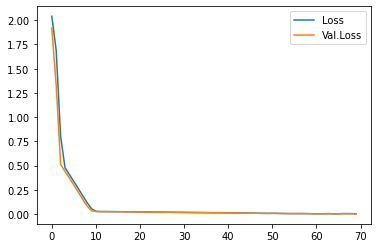

---------------------------------
LOSSES
train      0.003003676189109683
validation 0.0018013938097283244
test       0.16955643892288208
time elaps 0:00:12.701254


In [15]:
input = tf.keras.layers.Input(shape=(x.shape[1:]))

dense = NALU(128)(input)
output = NALU(1)(dense)

model = tf.keras.models.Model(
    inputs=input,
    outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss=tf.keras.losses.MeanAbsoluteError()
)

model.summary()

train_and_test(name='NALU')